In [1]:
# import libraries
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import cartopy.crs as ccrs
import s3fs
from shapely.geometry import Point, Polygon
from pyproj import CRS, Transformer

#from qaqc_utils import *

%matplotlib inline

In [2]:
# Helper function for plotting
def latlon_to_mercator_cartopy(lat, lon):
    proj_latlon = CRS('EPSG:4326')
    proj_mercator = CRS('EPSG:3857')
    
    # Transform the coordinates
    transformer = Transformer.from_crs(proj_latlon, proj_mercator, always_xy=True)
    x,y = transformer.transform(lon, lat)
    
    return x, y

# Shapefile of CA counties, for subsetting for a specific area
ca_counties = gpd.read_file("s3://wecc-historical-wx/0_maps/ca_counties/CA_Counties.shp" )

In [3]:
# Read in all stations
df_all = pd.read_csv("s3://wecc-historical-wx/2_clean_wx/temp_clean_all_station_list.csv")

# Subset for cleaned stations (Y flag)
df_clean = df_all.loc[df_all['cleaned'] == 'Y']
df_clean.head(5)

,Unnamed: 0,era-id,latitude,longitude,elevation,start-date,end-date,cleaned,time_cleaned,network,...,pr_nobs,pr_5min_nobs,pr_1h_nobs,pr_24h_nobs,pr_localmid_nobs,hurs_nobs,sfcwind_nobs,sfcwind_dir_nobs,rsds_nobs,total_nobs
0,0,ASOSAWOS_72681024131,43.567,-116.241,860.4504,1931-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-06 23:44:42+00:00,ASOSAWOS,...,400786.0,0.0,0.0,0.0,0.0,0.0,444433.0,379116.0,87216.0,470754.0
1,1,ASOSAWOS_72774024135,45.964,-112.501,1677.9240,2005-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 08:34:21+00:00,ASOSAWOS,...,131484.0,0.0,0.0,0.0,0.0,0.0,177652.0,121517.0,0.0,183432.0
2,2,ASOSAWOS_72571094025,40.481,-107.218,2011.6800,2005-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 08:44:41+00:00,ASOSAWOS,...,63539.0,0.0,0.0,0.0,0.0,0.0,371625.0,324697.0,0.0,374482.0
3,3,ASOSAWOS_72687600387,44.400,-118.967,1127.1504,2005-01-03 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 08:48:37+00:00,ASOSAWOS,...,14009.0,0.0,0.0,0.0,0.0,0.0,402892.0,320886.0,0.0,408311.0
4,4,ASOSAWOS_72020200118,45.417,-123.817,11.2776,2005-01-03 00:00:00+00:00,2022-12-31 00:00:00+00:00,Y,2023-02-07 08:46:35+00:00,ASOSAWOS,...,53279.0,0.0,0.0,0.0,0.0,0.0,397127.0,220449.0,0.0,401832.0


#### Example of subsetting for a variable + region
Looking at stations in the Santa Clara region for precipitation sensors

In [4]:
# Pick specific county
target_county = ca_counties[ca_counties['NAME'] == 'Santa Clara']

In [5]:
# Identify stations with precipitation sensors, looking for sensors with more than 5 observations to avoid stations that have a single observation
df_clean_pr = df_clean.loc[(df_clean[['pr_nobs', 'pr_5min_nobs', 'pr_1h_nobs', 'pr_24h_nobs', 'pr_localmid_nobs']] > 5).any(axis=1)]
df_clean_pr

# Option to output the subsetted stations with precip
df_clean_pr.to_csv('histobs_stns_all_precip.csv')

In [6]:
# Set up a map
geometry = [Point(latlon_to_mercator_cartopy(lat,lon)) for lat,lon in zip (df_clean.latitude, df_clean.longitude)]
pr_stns = gpd.GeoDataFrame(df_clean, geometry=geometry).set_crs(crs="EPSG:3857", allow_override=True) # adding geometry column
pr_stns = gpd.overlay(pr_stns, target_county, how="intersection") # subsetting for stations within county boundaries
print(f'Number of stations: {len(pr_stns)}')

Number of stations: 251


In [7]:
valley_water_stations = pr_stns[pr_stns['network']=='VALLEYWATER']
print(len(valley_water_stations))

45


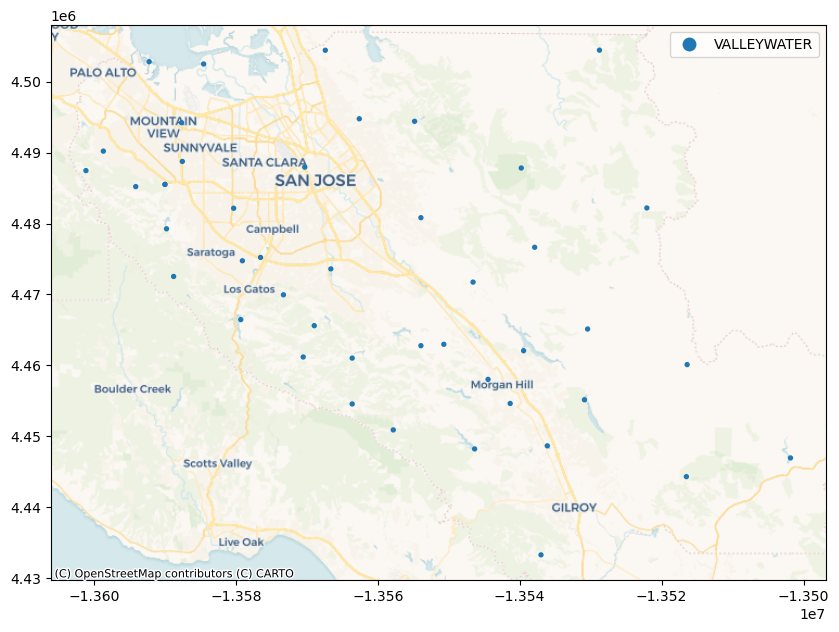

In [8]:
# Mapping
ax = valley_water_stations.plot(column='network', markersize=8, legend=True, figsize=(10,10))
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

# Also, can use your geodataframe and .explore() to zoom around
## pr_stns.explore()

## Pull all Valley Water QA/QC'd data

In [9]:
# Authenticate using AWS credentials
s3 = s3fs.S3FileSystem(anon=False)

# Define the correct parent S3 directory
parent_s3_path = "wecc-historical-wx/3_qaqc_wx/VALLEYWATER/"

# List available Zarr folders (fixing the duplicated path issue)
zarr_folders = [f"s3://{path}" for path in s3.ls(parent_s3_path) if path.endswith(".zarr")]

print("Found Zarr datasets:", zarr_folders)

# Read each Zarr dataset
datasets = {}

for zarr_path in zarr_folders:
    try:
        ds = xr.open_zarr(zarr_path, storage_options={"s3": {"anon": False}})
        datasets[zarr_path] = ds
        print(f"Loaded: {zarr_path}")
    except Exception as e:
        print(f"Error loading {zarr_path}: {e}")


Found Zarr datasets: ['s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6001.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6004.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6008.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6015.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6016.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6017.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6018.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6021.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6023.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6034.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6036.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6041.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6044.zarr', 's3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWA

In [10]:
for zarr_path, ds in datasets.items():
    print(f"Variables in {zarr_path}:")
    print(list(ds.data_vars))  # List of data variables (columns)
    print("\n")


Variables in s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6001.zarr:
['anemometer_height_m', 'elevation', 'elevation_eraqc', 'lat', 'lon', 'pr_15min', 'pr_15min_eraqc', 'raw_qc', 'thermometer_height_m']


Variables in s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6004.zarr:
['anemometer_height_m', 'elevation', 'elevation_eraqc', 'lat', 'lon', 'pr_15min', 'pr_15min_eraqc', 'raw_qc', 'thermometer_height_m']


Variables in s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6008.zarr:
['anemometer_height_m', 'elevation', 'elevation_eraqc', 'lat', 'lon', 'pr_15min', 'pr_15min_eraqc', 'raw_qc', 'thermometer_height_m']


Variables in s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6015.zarr:
['anemometer_height_m', 'elevation', 'elevation_eraqc', 'lat', 'lon', 'pr_15min', 'pr_15min_eraqc', 'raw_qc', 'thermometer_height_m']


Variables in s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6016.zarr:
['anemometer_height_m', 'elevation', 'elevatio

In [12]:
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point

# Function to convert lat/lon to geometry
def add_geometry_column(ds):
    """Adds a geometry column to an xarray dataset and returns a GeoDataFrame."""
    lat = ds['lat'].values
    lon = ds['lon'].values
    
    # Create geometry points
    geometry = [Point(lon, lat) for lon, lat in zip(ds['lon'].values.flatten(), ds['lat'].values.flatten())]
    
    # Convert xarray dataset to a pandas DataFrame
    df = ds.to_dataframe().reset_index()
    
    # Add geometry and convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    
    return gdf

# Iterate through datasets and add geometry
#geo_datasets = {zarr_path: add_geometry_column(ds) for zarr_path, ds in datasets.items()}


KeyboardInterrupt: 

In [13]:
# Pick one Zarr dataset to test
sample_zarr_path, sample_ds = next(iter(datasets.items()))  # Get first dataset

print(f"Testing with: {sample_zarr_path}")

# Run function on a single dataset
sample_gdf = add_geometry_column(sample_ds)

# Show first few rows to confirm
print(sample_gdf.head())

Testing with: s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_6001.zarr
            station                time  anemometer_height_m  elevation  \
0  VALLEYWATER_6001 1985-02-07 20:30:00                  NaN      58.73   
1  VALLEYWATER_6001 1985-02-07 20:45:00                  NaN      58.73   
2  VALLEYWATER_6001 1985-02-07 21:00:00                  NaN      58.73   
3  VALLEYWATER_6001 1985-02-07 21:15:00                  NaN      58.73   
4  VALLEYWATER_6001 1985-02-07 21:30:00                  NaN      58.73   

   elevation_eraqc      lat      lon  pr_15min  pr_15min_eraqc    raw_qc  \
0              3.0  37.2471 -121.871       0.0             NaN  Approved   
1              3.0  37.2471 -121.871       0.0             NaN  Approved   
2              3.0  37.2471 -121.871       0.0             NaN  Approved   
3              3.0  37.2471 -121.871       0.0             NaN  Approved   
4              3.0  37.2471 -121.871       0.0             NaN  Approved   

   thermom

In [ ]:
station_id = "VALLEYWATER_6001 "  # Replace with actual station ID

for zarr_path, ds in datasets.items():
    if "station" in ds:
        matching_idx = (ds["station"] == station_id).argmax().item()  # Find the index
        station_data = ds.isel(station=matching_idx, time=slice(0, 10))
        print(f"First 10 time steps for station {station_id} in {zarr_path}:\n", station_data.to_dataframe())


## Merge all stations precipitation data together, creating a single df

In [ ]:
# Create an empty list to store DataFrames from each station
station_dfs = []

num_stations = 50  # Process a subset first

for zarr_path, ds in datasets.items():
    if "station" in ds.dims and "time" in ds.dims:
        # Get station IDs (subset if needed)
        station_ids = ds["station"].values[:num_stations]

        for i, station_id in enumerate(station_ids):
            # Extract 'pr_15min_eraqc' and 'pr_15min' for this station
            station_data = ds.isel(station=i)[["pr_15min_eraqc", "pr_15min"]].to_dataframe()

            # Drop 'station' column if it exists
            if "station" in station_data.columns:
                station_data = station_data.drop(columns=["station"])

            # Rename columns to include the station ID
            station_data = station_data.rename(columns={
                "pr_15min_eraqc": f"pr_15min_eraqc_{station_id}",
                "pr_15min": f"pr_15min_{station_id}"
            })

            # Append to list
            station_dfs.append(station_data)

# Merge all station DataFrames on 'time'
merged_df = pd.concat(station_dfs, axis=1)

# Reset index to make 'time' a column
merged_df = merged_df.reset_index()

# Display result
print(len(merged_df))
print(merged_df.head(10))

In [ ]:
# Replace zeros with NaN to ignore them in calculations
merged_df_no_zeros = merged_df.replace(0, np.nan)

# Compute descriptive statistics excluding zeros
print(merged_df_no_zeros.describe())


In [ ]:
# Replace zeros with NaN to ignore them in calculations
merged_df_no_zeros = merged_df.replace(0, np.nan)

# Compute descriptive statistics excluding zeros
print(merged_df_no_zeros.describe())


In [ ]:
# Summary statistics for all station columns
print(merged_df.describe())


In [ ]:
# Pick two random stations
station1, station2 = merged_df.columns[1], merged_df.columns[21]

# Compute absolute difference
diff = (merged_df[station1] - merged_df[station2]).abs()

# Print summary of differences
print(f"Difference between {station1} and {station2}:")
print(diff.describe())


## Pull Santa Clara Watershed Data from Valley Water

In [ ]:
santa_clara_watershed_data = 's3://wecc-historical-wx/0_maps/Santa_Clara_County_Watersheds/'

In [ ]:
santa_clara_watersheds = gpd.read_file(santa_clara_watershed_data)


In [ ]:
santa_clara_watersheds